<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Base/HW1_Regression_with_inference_base_pt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (base). Часть 1**

В этом домашнем задании вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;

**Максимальная оценка за дз**
> Оценка за первую часть домашки = $min(\text{ваш балл}, 7)$


**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.**

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [904]:
import pandas as pd
import numpy as np

import random
import pickle
import os
import warnings

import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

from collections import Counter

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, ElasticNet, Lasso, LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error as MSE, mean_absolute_error as MAE

random.seed(42)
np.random.seed(42)

warnings.filterwarnings("ignore", message="use_inf_as_na.*", category=FutureWarning)

%matplotlib inline

Давайте зафиксируем важный момент.

**Задание 0 (0 баллов).**
Изучите и ответье на вопрос: для чего фиксируем сиды в домашках?

Фиксируем сиды, чтобы сделать результаты экспериментов воспроизводимыми. В генераторах случайных чисел (random и NumPy) одни и те же сиды дают одну и ту же последовательность «случайных» чисел. Это значит, что разбиение на train/test, перемешивание данных, инициализация весов и т.п. каждый запуск будут происходить одинаково, и метрики модели не будут случайно «скакать» от запуска к запуску.

# **Часть 1 | EDA и визуализация**

Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (2.5 балла)
- Визуализации признаков и их анализ (1 балл)

Всего можно набрать 3.5 основных балла и 0.65 бонусных. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (2.5 балла)**

In [905]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


In [906]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6999 non-null   object 
 1   year           6999 non-null   int64  
 2   selling_price  6999 non-null   int64  
 3   km_driven      6999 non-null   int64  
 4   fuel           6999 non-null   object 
 5   seller_type    6999 non-null   object 
 6   transmission   6999 non-null   object 
 7   owner          6999 non-null   object 
 8   mileage        6797 non-null   object 
 9   engine         6797 non-null   object 
 10  max_power      6803 non-null   object 
 11  torque         6796 non-null   object 
 12  seats          6797 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 711.0+ KB


In [907]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           1000 non-null   object 
 1   year           1000 non-null   int64  
 2   selling_price  1000 non-null   int64  
 3   km_driven      1000 non-null   int64  
 4   fuel           1000 non-null   object 
 5   seller_type    1000 non-null   object 
 6   transmission   1000 non-null   object 
 7   owner          1000 non-null   object 
 8   mileage        981 non-null    object 
 9   engine         981 non-null    object 
 10  max_power      981 non-null    object 
 11  torque         981 non-null    object 
 12  seats          981 non-null    float64
dtypes: float64(1), int64(3), object(9)
memory usage: 101.7+ KB


### **Задание 1 (0.5 балла)**

Вы уже встречались с pandas в первой половине семестра. Теперь будем постоянно (кроме некоторых случаев) использовать его для анализа данных и наслаивать навыки. Выполните операции, направленные на практику основных действий с `pandas`:

**0.1 балла**
- [ ] Отобразите 30 случайных строк тренировочного датасета.
- [ ] Отобразите первые 5 и последние 5 объектов тестового датасета
- [ ] Посмотрите, есть ли в датасете пропуски. Запишите/выведите названия колонок, для которых есть пропущенные значения
- [ ] Посмотрите, есть ли в данных явные дубликаты


**0.2 балла**
Ответьте на вопросы:
- [ ] Выводы о чем можно сделать, используя случайные/верхние/нижние строки? А о чем нельзя?
- [ ] Достаточно ли метода duplicated для анализа дубликатов? Почему?

**0.15 балла**
- [ ] Постройте дашборд, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)

In [908]:
df_train.isna().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          202
engine           202
max_power        196
torque           203
seats            202
dtype: int64

In [909]:
df_train

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6994,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
6995,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110 bhp,"24@ 1,900-2,750(kgm@ rpm)",5.0
6996,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0
6997,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0


In [910]:
df_train.sample(n=30)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
6565,Renault KWID Climber 1.0 MT BSIV,2019,300000,35000,Petrol,Individual,Manual,First Owner,23.01 kmpl,999 CC,67 bhp,91Nm@ 4250rpm,5.0
2943,Maruti Wagon R LXI,2013,225000,58343,Petrol,Trustmark Dealer,Manual,First Owner,21.79 kmpl,998 CC,67.05 bhp,90Nm@ 3500rpm,5.0
2024,Hyundai i20 Asta 1.2,2013,360000,30000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
263,Hyundai i20 1.2 Asta,2010,300000,70000,Petrol,Individual,Manual,First Owner,17.0 kmpl,1197 CC,80 bhp,"11.4 kgm at 4,000 rpm",5.0
4586,Skoda Octavia L and K 1.9 TDI MT,2005,250000,120000,Diesel,Individual,Manual,Third Owner,16.4 kmpl,1896 CC,90 bhp,"21.4@ 1,900(kgm@ rpm)",5.0
4479,Maruti Ciaz ZXi,2016,700000,20000,Petrol,Individual,Manual,First Owner,20.73 kmpl,1373 CC,91.1 bhp,130Nm@ 4000rpm,5.0
4881,Hyundai Grand i10 1.2 Kappa Magna BSIV,2017,445000,27000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0
3583,Ford Ecosport 1.5 DV5 MT Trend,2016,515000,68609,Diesel,Dealer,Manual,First Owner,22.7 kmpl,1498 CC,89.84 bhp,204Nm@ 2000-2750rpm,5.0
6361,Hyundai Verna 1.4 VTVT,2014,500000,33400,Petrol,Individual,Manual,First Owner,17.43 kmpl,1396 CC,105.5 bhp,135.3Nm@ 5000rpm,5.0
4108,Hyundai i20 Era 1.2,2015,490000,45900,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,81.83 bhp,114.7Nm@ 4000rpm,5.0


In [911]:
df_test.head(5)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0 kmpl,2498 CC,112 bhp,260 Nm at 1800-2200 rpm,7.0
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5 kmpl,1497 CC,108.5 bhp,260Nm@ 1500-2750rpm,5.0
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9 kmpl,1799 CC,130 bhp,172Nm@ 4300rpm,5.0
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5 kmpl,1172 CC,65 bhp,96 Nm at 3000 rpm,5.0


In [912]:
df_test.tail(5)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
995,Hyundai i10 Magna 1.1L,2008,250000,100000,Petrol,Individual,Manual,Second Owner,19.81 kmpl,1086 CC,68.05 bhp,99.04Nm@ 4500rpm,5.0
996,Hyundai i20 2015-2017 Sportz 1.2,2017,440000,50000,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,81.83 bhp,114.7Nm@ 4000rpm,5.0
997,Hyundai i20 Era Diesel,2009,340000,40000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
998,Hyundai i10 Asta,2012,350000,25000,Petrol,Individual,Manual,First Owner,20.36 kmpl,1197 CC,78.9 bhp,111.8Nm@ 4000rpm,5.0
999,Honda City i DTec SV,2016,700000,110000,Diesel,Individual,Manual,First Owner,26.0 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0


In [913]:
df_train.isna().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          202
engine           202
max_power        196
torque           203
seats            202
dtype: int64

In [914]:
df_test.isna().sum()

name              0
year              0
selling_price     0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage          19
engine           19
max_power        19
torque           19
seats            19
dtype: int64

In [915]:
df_train.duplicated().sum()

np.int64(985)

In [916]:
df_test.duplicated().sum()

np.int64(62)

In [917]:
profile_train = ProfileReport(df_train, title="Profiling Report")

In [918]:
profile_train

ModuleNotFoundError: No module named 'ipywidgets'

In [919]:
profile_test = ProfileReport(df_test, title="Profiling Report")

In [920]:
profile_test

ModuleNotFoundError: No module named 'ipywidgets'

Мы обнаружили пропуски. Давайте избавимся от них.

**(0.05 балла)**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось. Заполнение пропусков проводите для обоих наборов данных, если необходимо

**Важно!**

При заполнении пропусков и в тестовом, и тренировочном наборах данных вы определяетесь со стратегией предобработки пропущенных значений при потенциальной работе модели.

Так как в теоретическом случае вы не имеете доступа к тестовой выборке, то заполняемой значение (у нас — медиана) вы считаете про *тренировочному* набору данных и им же заполняете *тестовый*.

In [921]:
nan_cat = ["mileage", "engine", "max_power", "seats"]

for col in nan_cat:
    def safe_extract_number(val):
        if pd.isna(val):
            return np.nan
        parts = str(val).split()
        if not parts:
            return np.nan
        number_str = parts[0]
        try:
            return float(number_str)
        except ValueError:
            return np.nan

    df_train[col] = df_train[col].apply(safe_extract_number)
    df_test[col] = df_test[col].apply(safe_extract_number)

    median_val = df_train[col].median()
    df_train[col] = df_train[col].fillna(median_val)
    df_test[col] = df_test[col].fillna(median_val)

In [922]:
df_train.isna().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage            0
engine             0
max_power          0
torque           203
seats              0
dtype: int64

In [923]:
df_train.shape

(6999, 13)

In [924]:
df_test.isna().sum()

name              0
year              0
selling_price     0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage           0
engine            0
max_power         0
torque           19
seats             0
dtype: int64

In [925]:
df_train.torque.unique()

array(['190Nm@ 2000rpm', '250Nm@ 1500-2500rpm',
       '22.4 kgm at 1750-2750rpm', '11.5@ 4,500(kgm@ rpm)',
       '113.75nm@ 4000rpm', '7.8@ 4,500(kgm@ rpm)', '59Nm@ 2500rpm',
       '170Nm@ 1800-2400rpm', '160Nm@ 2000rpm', '248Nm@ 2250rpm',
       '78Nm@ 4500rpm', nan, '84Nm@ 3500rpm', '115Nm@ 3500-3600rpm',
       '62Nm@ 3000rpm', '219.7Nm@ 1500-2750rpm', '200Nm@ 1750rpm',
       '115Nm@ 4000rpm', '69Nm@ 3500rpm', '172.5Nm@ 1750rpm',
       '6.1kgm@ 3000rpm', '60Nm@ 3500rpm', '90Nm@ 3500rpm',
       '151Nm@ 4850rpm', '104Nm@ 4000rpm', '320Nm@ 1700-2700rpm',
       '250Nm@ 1750-2500rpm', '145Nm@ 4600rpm', '146Nm@ 4800rpm',
       '343Nm@ 1400-3400rpm', '200Nm@ 1400-3400rpm',
       '200Nm@ 1250-4000rpm', '400Nm@ 2000-2500rpm',
       '360Nm@ 1200-3400rpm', '200Nm@ 1200-3600rpm',
       '380Nm@ 1750-2500rpm', '400Nm@ 1750-3000rpm',
       '400Nm@ 1400-2800rpm', '200Nm@ 1750-3000rpm', '111.7Nm@ 4000rpm',
       '219.6Nm@ 1500-2750rpm', '112Nm@ 4000rpm', '250Nm@ 1500-3000rpm',
       '1

In [926]:
# torque имеет сложную стркутуру данных (можно было бы разделить на ... и ...)

### **Задание 2 (0.5 балла)**

На прошлом шаге вы убедились, что явных дубликатов в таблице нет. Однако дубликат может быть связан с не только полным повторением информации в нескольких строках, но и частиным. Например, объект мог был внесен в базу данных с разным значением целевой переменной. В этом шаге займемся такими дублями!

**Ваши действия:**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.1 балла)
- [ ] Отобразите такие объекты (0.15 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.15 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.1 балла)


In [927]:
df_train.shape

(6999, 13)

In [928]:
features = df_train.columns.difference(['selling_price'])

duplicates_mask = df_train.duplicated(subset=features, keep=False)
duplicates_count = duplicates_mask.sum()

print(duplicates_count)

duplicates = df_train[duplicates_mask]
print(duplicates)

df_train = df_train.drop_duplicates(subset=features, keep='first').reset_index(drop=True)

1799
                                          name  year  selling_price  \
22                     Maruti Baleno Delta 1.2  2016         575000   
26                 Maruti Omni E MPI STD BS IV  2018         254999   
27             Maruti Vitara Brezza LDi Option  2017         670000   
28                          Fiat Palio 1.2 ELX  2003          70000   
29                   Maruti Omni 8 Seater BSIV  2012         150000   
...                                        ...   ...            ...   
6981  Ford Freestyle Titanium Plus Diesel BSIV  2018         750000   
6984  Ford Freestyle Titanium Plus Diesel BSIV  2018         746000   
6989                    Maruti Swift Dzire VDI  2015         625000   
6997                           Tata Indigo CR4  2013         290000   
6998                           Tata Indigo CR4  2013         290000   

      km_driven    fuel seller_type transmission         owner  mileage  \
22        45000  Petrol  Individual       Manual   First Owner    2

In [929]:
assert df_train.shape == (5840, 13)

In [930]:
df_train.duplicated().sum()

np.int64(0)

Отлично! Мы избавились от маленьких и явных проблем. Теперь перейдем к более сложным недостаткам полученной таблицы.

### **Задание 3 (0.25 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Удалите столбец ``torque``


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.
- Стобец ``torque`` мы удаляем для простоты. В идеальном случае, его также стоило бы предобработать.

In [931]:
df_train.mileage

0       23.40
1       21.14
2       23.00
3       16.10
4       20.14
        ...  
5835    17.92
5836    18.90
5837    18.50
5838    16.80
5839    19.30
Name: mileage, Length: 5840, dtype: float64

In [932]:
df_train.engine

0       1248.0
1       1498.0
2       1396.0
3       1298.0
4       1197.0
         ...  
5835    1086.0
5836     998.0
5837    1197.0
5838    1493.0
5839    1248.0
Name: engine, Length: 5840, dtype: float64

In [933]:
df_train.max_power

0        74.00
1       103.52
2        90.00
3        88.20
4        81.86
         ...  
5835     62.10
5836     67.10
5837     82.85
5838    110.00
5839     73.90
Name: max_power, Length: 5840, dtype: float64

In [934]:
df_train['mileage'] = df_train['mileage'].apply(
    lambda x: float(x.split()[0]) if isinstance(x, str) else x
)

In [935]:
df_train['engine'] = df_train['engine'].apply(
    lambda x: float(x.split()[0]) if isinstance(x, str) else x
)

In [936]:
df_train['max_power'] = df_train['max_power'].apply(
    lambda x: float(x.split()[0]) if isinstance(x, str) else x
)

In [ ]:
df_train = df_train.drop('torque', axis=1)

In [938]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           5840 non-null   object 
 1   year           5840 non-null   int64  
 2   selling_price  5840 non-null   int64  
 3   km_driven      5840 non-null   int64  
 4   fuel           5840 non-null   object 
 5   seller_type    5840 non-null   object 
 6   transmission   5840 non-null   object 
 7   owner          5840 non-null   object 
 8   mileage        5840 non-null   float64
 9   engine         5840 non-null   float64
 10  max_power      5840 non-null   float64
 11  seats          5840 non-null   float64
dtypes: float64(4), int64(3), object(5)
memory usage: 547.6+ KB


In [939]:
df_test['mileage'] = df_test['mileage'].apply(
    lambda x: float(x.split()[0]) if isinstance(x, str) else x
)

In [940]:
df_test['engine'] = df_test['engine'].apply(
    lambda x: float(x.split()[0]) if isinstance(x, str) else x
)

In [941]:
df_test['max_power'] = df_test['max_power'].apply(
    lambda x: float(x.split()[0]) if isinstance(x, str) else x
)

In [942]:
df_test = df_test.drop('torque', axis=1)

In [943]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           1000 non-null   object 
 1   year           1000 non-null   int64  
 2   selling_price  1000 non-null   int64  
 3   km_driven      1000 non-null   int64  
 4   fuel           1000 non-null   object 
 5   seller_type    1000 non-null   object 
 6   transmission   1000 non-null   object 
 7   owner          1000 non-null   object 
 8   mileage        1000 non-null   float64
 9   engine         1000 non-null   float64
 10  max_power      1000 non-null   float64
 11  seats          1000 non-null   float64
dtypes: float64(4), int64(3), object(5)
memory usage: 93.9+ KB


### **Задание 4 (0.1 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.

In [944]:
df_train.engine = df_train.engine.apply(lambda x: int(x))

In [945]:
df_train.seats = df_train.seats.apply(lambda x: int(x))

In [946]:
df_test.engine = df_test.engine.apply(lambda x: int(x))

In [947]:
df_test.seats = df_test.seats.apply(lambda x: int(x))

In [948]:
df_train.dtypes

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage          float64
engine             int64
max_power        float64
seats              int64
dtype: object

In [949]:
df_test.dtypes

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage          float64
engine             int64
max_power        float64
seats              int64
dtype: object

### **Задание 5 (0.15 балла)**

Отлично! Мы провели "косметическую" предобработку и теперь готовы сделать важный шаг в контексте анализа данных. А именно — посмотреть на статистики!

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сделайте вывод.

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

**Примечание:**

Более корректно рассматривать статистики до заполнения пропусков и после, чтобы убедиться, что мы не внесли каких-либо серьезных сдвигов в изначальные рапсределения.

In [950]:
df_train.describe()

,year,selling_price,km_driven,mileage,engine,max_power,seats
count,5840.000000,5.840000e+03,5.840000e+03,5840.000000,5840.000000,5840.000000,5840.000000
mean,2013.428425,5.229601e+05,7.395224e+04,19.428611,1429.448973,87.910782,5.426712
std,4.095622,5.354320e+05,6.007114e+04,3.986026,485.662834,31.639585,0.982344
min,1983.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,0.000000,2.000000
25%,2011.000000,2.500000e+05,3.900000e+04,16.950000,1197.000000,68.000000,5.000000
50%,2014.000000,4.050000e+05,7.000000e+04,19.300000,1248.000000,81.860000,5.000000
75%,2017.000000,6.400000e+05,1.000000e+05,22.300000,1498.000000,99.000000,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,14.000000


In [951]:
df_test.describe()

,year,selling_price,km_driven,mileage,engine,max_power,seats
count,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,2013.681000,6.179010e+05,71393.341000,19.337480,1454.87600,90.844330,5.403000
std,4.012149,7.585539e+05,48486.218662,3.951751,521.99574,34.892709,0.912921
min,1995.000000,3.100000e+04,1303.000000,0.000000,624.00000,34.200000,4.000000
25%,2011.000000,2.500000e+05,37000.000000,16.550000,1197.00000,69.000000,5.000000
50%,2014.000000,4.349990e+05,61500.000000,19.300000,1248.00000,82.425000,5.000000
75%,2017.000000,6.700000e+05,100000.000000,22.300000,1582.00000,102.000000,5.000000
max,2020.000000,6.000000e+06,375000.000000,32.260000,3604.00000,280.000000,9.000000


In [952]:
df_train.describe(include=["object"])

,name,fuel,seller_type,transmission,owner
count,5840,5840,5840,5840,5840
unique,1924,4,3,2,5
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner
freq,91,3177,5223,5336,3603


In [953]:
df_test.describe(include=["object"])

,name,fuel,seller_type,transmission,owner
count,1000,1000,1000,1000,1000
unique,621,4,3,2,5
top,Maruti Alto 800 LXI,Diesel,Individual,Manual,First Owner
freq,15,534,837,877,623


тут будет вывод...

In [954]:
assert df_train.shape == (5840, 12)

## **Визуализации (1 балл + 0.5 бонус)**



Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 6 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

In [955]:
# df_train.to_csv('app/files/df_train.csv', index=False)

In [956]:
# df_test.to_csv('app/files/df_test.csv', index=False)

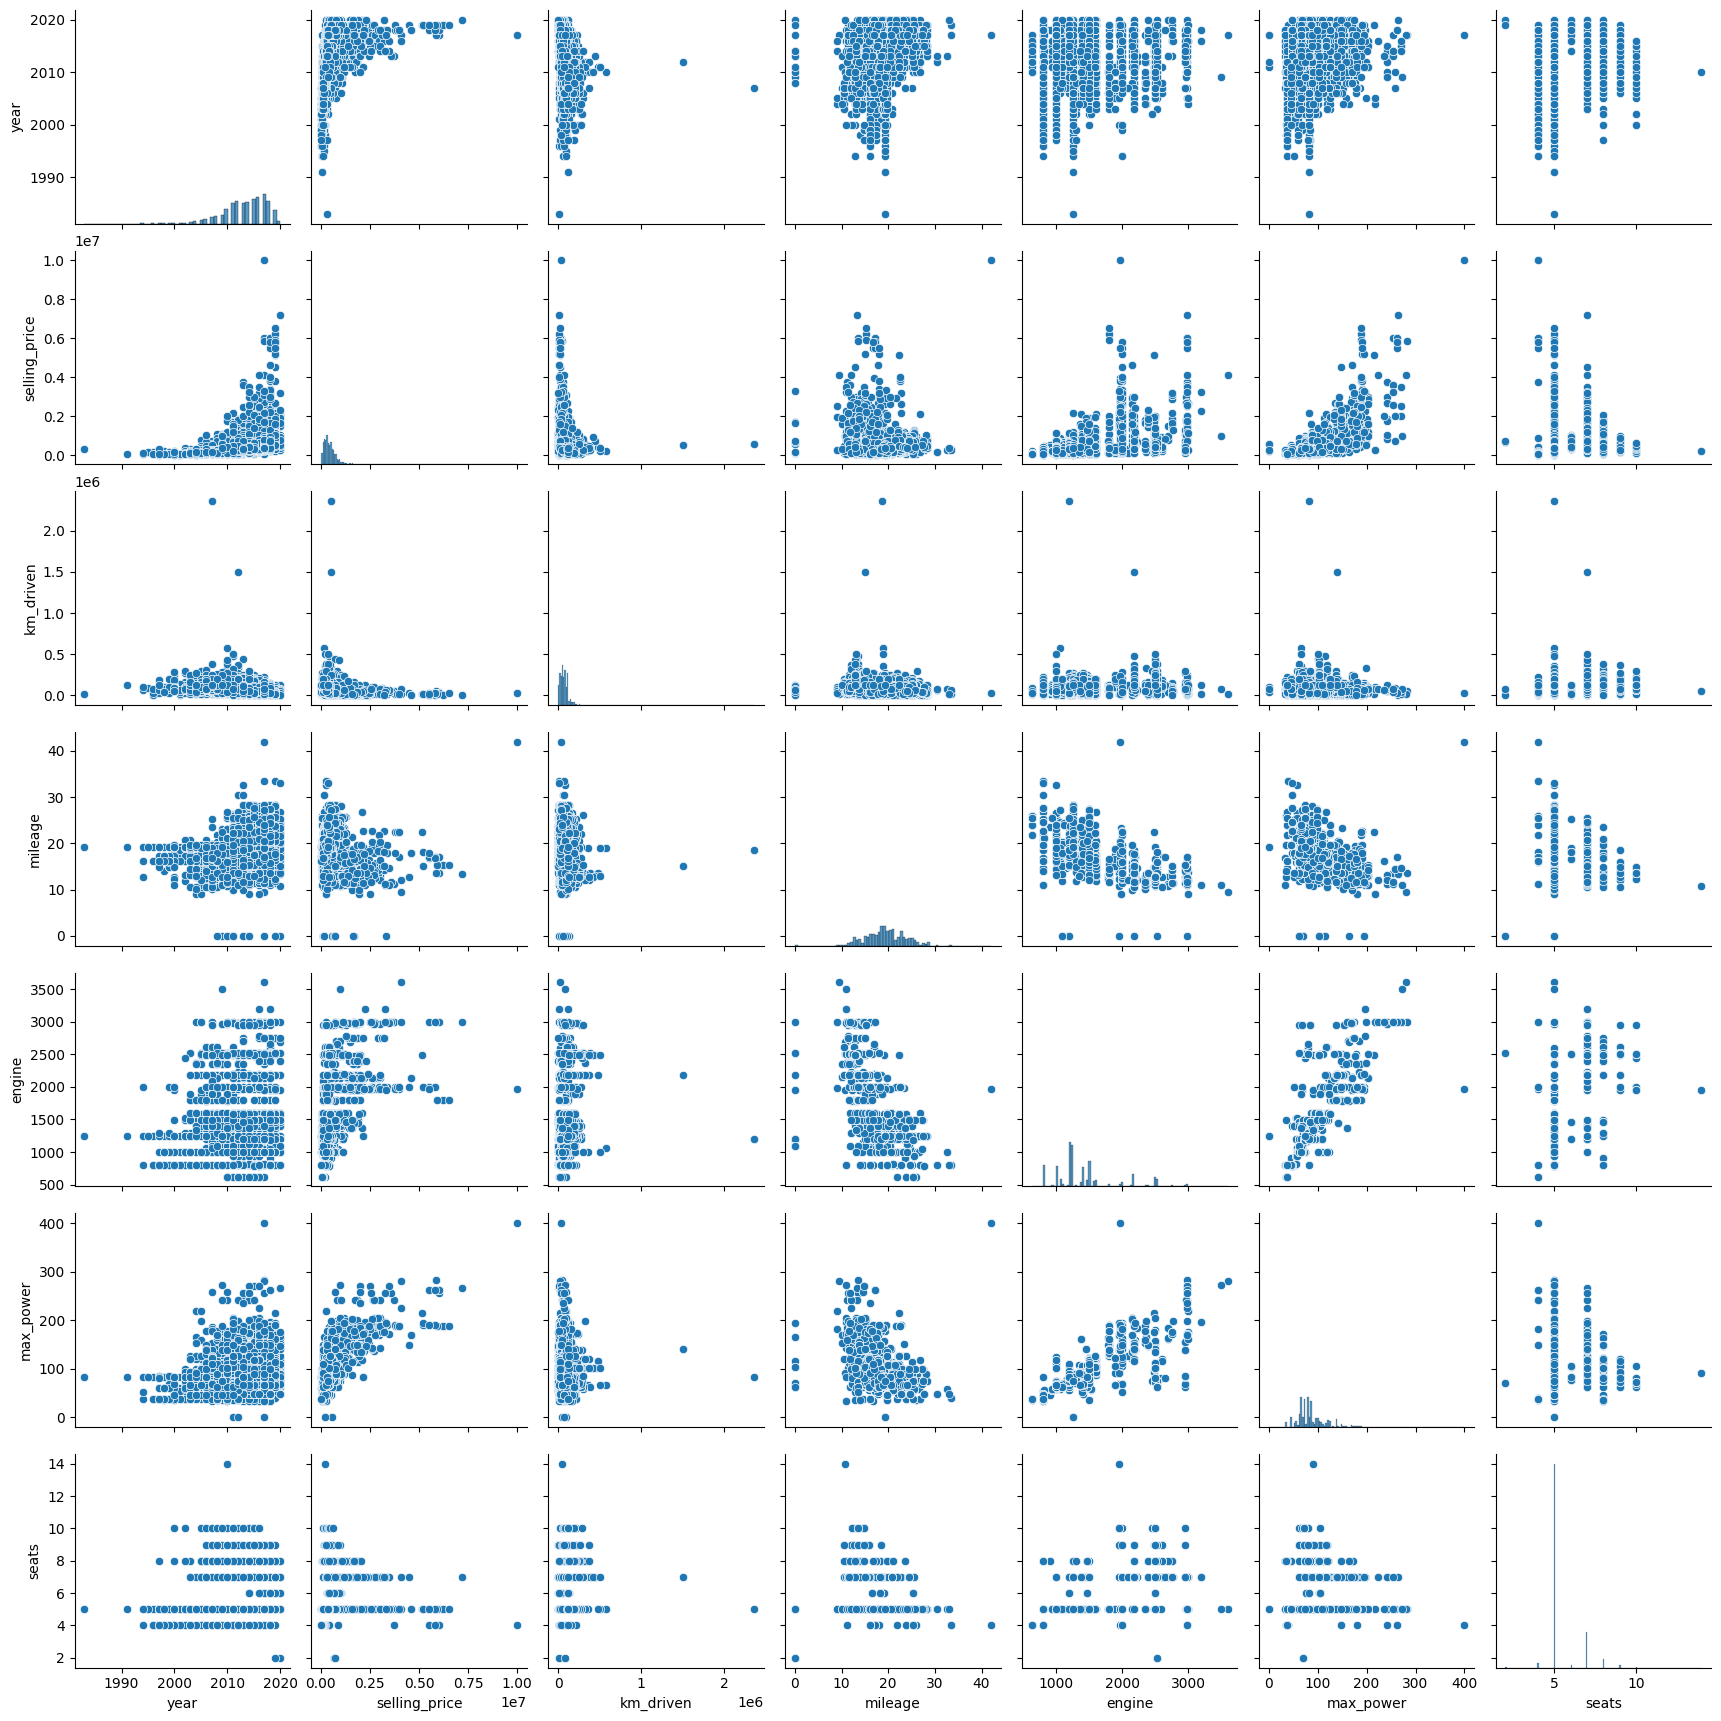

In [957]:
sns.pairplot(df_train.select_dtypes(include=['number']))
plt.show()

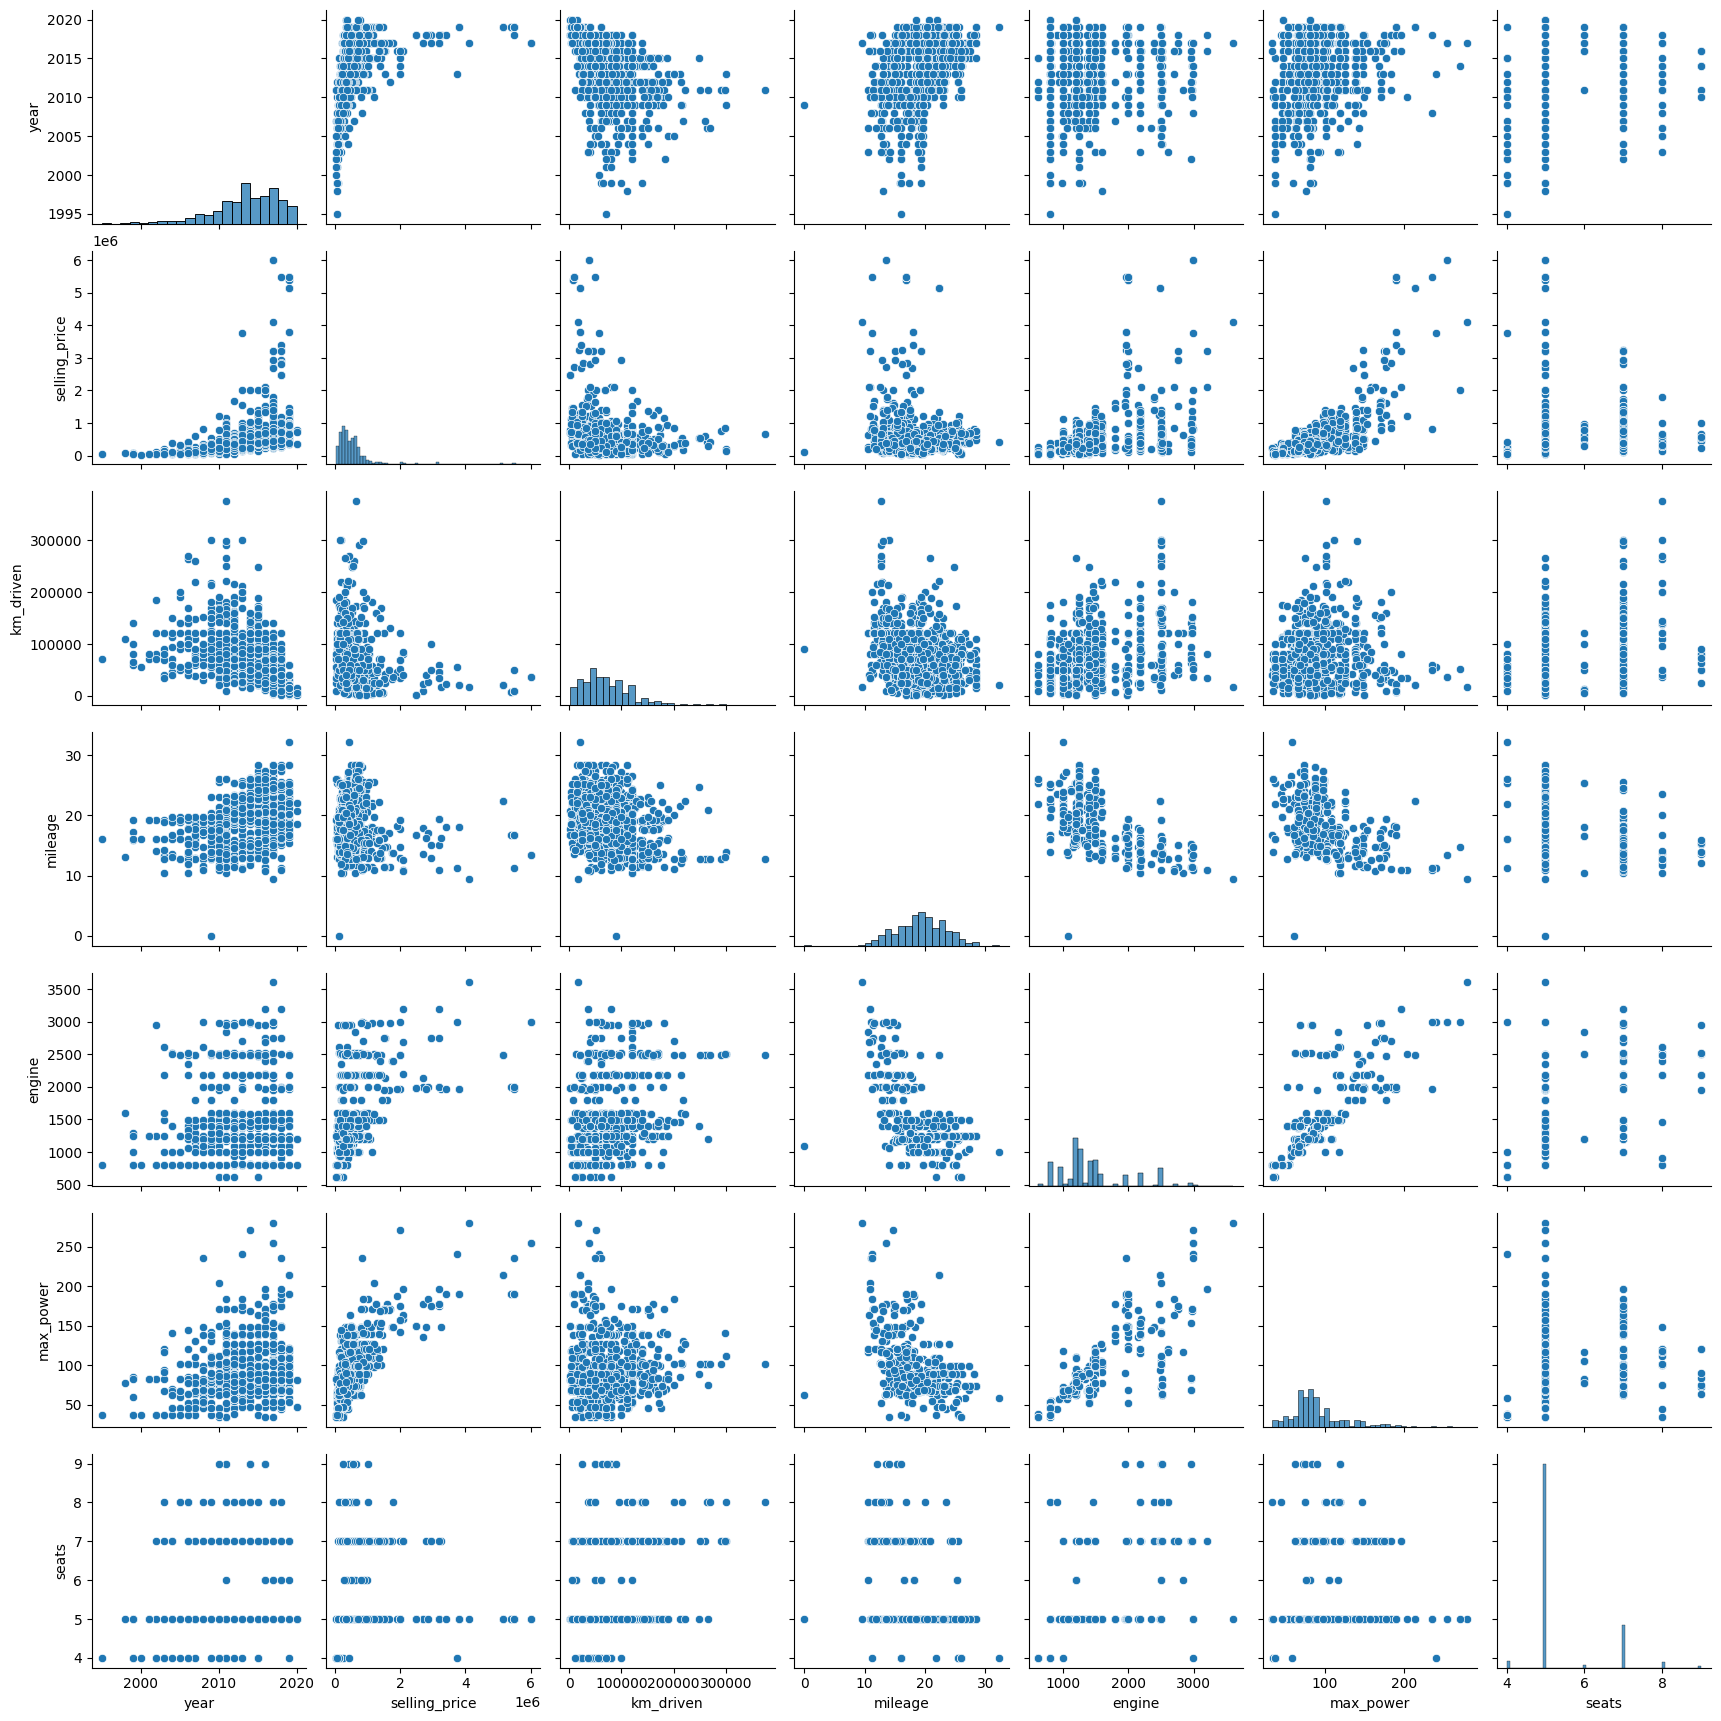

In [958]:
sns.pairplot(df_test.select_dtypes(include=['number']))
plt.show()

`Your answer here`

### **Задание 7 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)


In [959]:
train_corr_matrix = df_train.select_dtypes(include=["number"]).corr()

In [960]:
train_corr_matrix

,year,selling_price,km_driven,mileage,engine,max_power,seats
year,1.000000,0.427279,-0.368966,0.342172,0.002819,0.156648,0.041178
selling_price,0.427279,1.000000,-0.164828,-0.104458,0.447672,0.692754,0.149953
km_driven,-0.368966,-0.164828,1.000000,-0.182245,0.229766,0.024630,0.192328
mileage,0.342172,-0.104458,-0.182245,1.000000,-0.572677,-0.373271,-0.450810
engine,0.002819,0.447672,0.229766,-0.572677,1.000000,0.681082,0.652172
max_power,0.156648,0.692754,0.024630,-0.373271,0.681082,1.000000,0.244060
seats,0.041178,0.149953,0.192328,-0.450810,0.652172,0.244060,1.000000


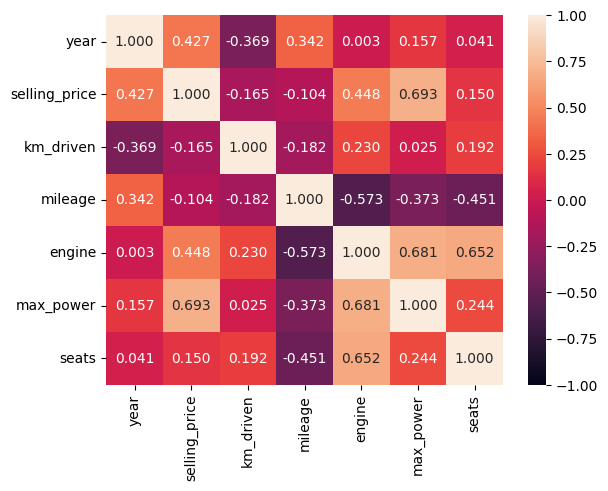

In [961]:
sns.heatmap(train_corr_matrix, annot=True, fmt=".3f", vmin=-1, vmax=1)
plt.show()

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?

`Your answer here`

### **Бонус (0.5 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их **и поясните.**

- Каждая дополнительная визуализация может принести до 0.25 баллов при условии, что она обоснована.

Нам важно посмотреть на распределение целевой переменной, чтобы понять сконцентрирована ли основная масса значений сверху или снизу. Это даст возможность использовать в дальнейшей разработки модели np.log(target) - это позволит сделать распределение более симметричным

# **Часть 2 | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.25 балла;

### **Задание 8 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [962]:
df_train_copy = df_train.select_dtypes(include=["number"])

X_train = df_train_copy.drop(columns=["selling_price"])
y_train = df_train_copy["selling_price"]

In [963]:
assert X_train.shape == (5840, 6)

In [964]:
df_test_copy = df_test.select_dtypes(include=["number"])

X_test = df_test_copy.drop(columns=["selling_price"])
y_test = df_test_copy["selling_price"]

In [965]:
X_test.shape

(1000, 6)

In [966]:
assert X_test.shape == (1000, 6)

### **Задание 9 (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [967]:
# можно использовать логарифмирование target переменной (y) - np.log(target)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [968]:
y_train_pred = lin_reg.predict(X_train)
y_test_pred  = lin_reg.predict(X_test)

In [969]:
r2_train = r2_score(y_train, y_train_pred)
mse_train = MSE(y_train, y_train_pred)
rmse_train = mse_train ** 0.5

In [970]:
r2_test = r2_score(y_test, y_test_pred)
mse_test = MSE(y_test, y_test_pred)
rmse_test = mse_test ** 0.5

In [971]:
print(r2_train, mse_train, rmse_train)

0.592262959584988 116873067751.52148 341867.0322676954


In [972]:
print(r2_test, mse_test, rmse_test)

0.5941441219017108 233297548204.6121 483008.84899203666


### **Задание 10 (0.15 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [973]:
scaler = StandardScaler()

scaler.fit(X_train, y_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [974]:
lin_reg_scaled = LinearRegression()
lin_reg_scaled.fit(X_train_scaled, y_train)

y_train_pred_scaled = lin_reg_scaled.predict(X_train_scaled)
y_test_pred_scaled  = lin_reg_scaled.predict(X_test_scaled)

r2_train_scaled = r2_score(y_train, y_train_pred_scaled)
r2_test_scaled  = r2_score(y_test, y_test_pred_scaled)

mse_train_scaled = MSE(y_train, y_train_pred_scaled)
mse_test_scaled  = MSE(y_test, y_test_pred_scaled)

rmse_train_scaled = mse_train_scaled ** 0.5
rmse_test_scaled = mse_test_scaled ** 0.5

In [975]:
print(r2_train_scaled, mse_train_scaled, rmse_train_scaled)

0.5922629595849875 116873067751.52162 341867.0322676956


In [976]:
print(r2_test_scaled, mse_test_scaled, rmse_test_scaled)

0.594144121901726 233297548204.60333 483008.84899202763


### **Задание 11 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [977]:
# your code here

### **Задание 12 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [978]:
lasso = Lasso(alpha=1.0, random_state=42, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

y_train_pred_lasso = lasso.predict(X_train_scaled)
y_test_pred_lasso = lasso.predict(X_test_scaled)

r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
r2_test_lasso = r2_score(y_test, y_test_pred_lasso)

mse_train_lasso = MSE(y_train, y_train_pred_lasso)
mse_test_lasso = MSE(y_test, y_test_pred_lasso)

rmse_train_lasso = mse_train_lasso ** 0.5
rmse_test_lasso = mse_test_lasso ** 0.5

In [979]:
print(r2_train_lasso, mse_train_lasso, rmse_train_lasso)

0.5922629595497046 116873067761.63501 341867.032282487


In [980]:
print(r2_test_lasso, mse_test_lasso, rmse_test_lasso)

0.5941429546560311 233298219170.76025 483009.54356074607


In [981]:
coef = lasso.coef_
print("Коэффициенты:", coef)

n_zero = np.sum(coef == 0)
n_all  = coef.size
print(f"Нулевых коэффициентов: {n_zero} из {n_all}")

Коэффициенты: [152843.08385345 -44146.91853785  28779.20408499  61172.02578008
 322780.58619708 -23217.69327311]
Нулевых коэффициентов: 0 из 6


### **Задание 13 Финальный рывок (0.5 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [982]:
lasso = Lasso(random_state=42, max_iter=10000)

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000, 10000],
}

grid_search_lasso = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,
    cv=10,
    scoring='r2',
    n_jobs=-1
)

grid_search_lasso.fit(X_train_scaled, y_train)

best_lasso = grid_search_lasso.best_estimator_

print("Лучшие параметры Lasso:", grid_search_lasso.best_params_)
print("Лучший скор (R²):", grid_search_lasso.best_score_)

y_train_pred_lasso_grid = best_lasso.predict(X_train_scaled)
y_test_pred_lasso_grid = best_lasso.predict(X_test_scaled)

print("Веса:", best_lasso.coef_)

Лучшие параметры Lasso: {'alpha': 10000}
Лучший скор (R²): 0.5727300261493131
Веса: [151898.11359496 -32723.29920873   9238.17045228  17841.93520051
 329198.99021342     -0.        ]


#### `тут будет текст`

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [983]:
elastic = ElasticNet(random_state=42, max_iter=100000)

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000, 10000],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]}

grid_search_elastic = GridSearchCV(
    estimator=elastic,
    param_grid=param_grid,
    cv=10,
    scoring='r2',
    n_jobs=-1
)

grid_search_elastic.fit(X_train_scaled, y_train)

best_elastic = grid_search_elastic.best_estimator_

print("Лучшие параметры:", grid_search_elastic.best_params_)
print("Лучший скор (R²):", grid_search_elastic.best_score_)

y_train_pred_elastic = best_elastic.predict(X_train_scaled)
y_test_pred_elastic = best_elastic.predict(X_test_scaled)

print("Веса:", best_elastic.coef_)

Лучшие параметры: {'alpha': 1.0, 'l1_ratio': 0.9}
Лучший скор (R²): 0.5761378555173833
Веса: [146041.11461375 -46021.21571588  22845.76274071  79237.72636177
 281536.65815575 -24516.39609253]


#### `тут будет текст`

# **Часть 3| Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.75 основных балла и 0.25 бонусных.


**Задание 14 (0.1 балла)** Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

В этом домашнем задании мы предлагаем удалить его.

**Ваша задача:**
- [ ] Удалить столбец`name`

В другом случае, конечно, мы могли бы предобработать данный столбец. В качестве бонуса предлагаем вам придумать и реализовать алгоритм предобработки.

**Бонус 0.25 балла**
- [ ] Предобработайте столбец `name`, чтобы избежать его удаления. Если предобработали столбец — можно закомментировать assert

*идея в том чтобы выявить закономерность стоимости автомобиля от его названия (модель + бренд), высчитаем среднюю цену по марке и моделе, тем самым дадим модели еще один важный признак на который она сможет опираться*

In [984]:
selling_prices_sorted = df_train.sort_values(by='selling_price', ascending=False)

In [985]:
selling_prices_sorted.head(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
151,Volvo XC90 T8 Excellence BSIV,2017,10000000,30000,Petrol,Individual,Automatic,First Owner,42.00,1969,400.00,4
2283,BMW X7 xDrive 30d DPE,2020,7200000,5000,Diesel,Individual,Automatic,First Owner,13.38,2993,265.00,7
3597,Audi A6 35 TFSI Matrix,2019,6523000,23600,Petrol,Dealer,Automatic,Test Drive Car,15.26,1798,187.74,5
3595,Audi A6 35 TFSI Matrix,2019,6223000,7800,Petrol,Dealer,Automatic,Test Drive Car,15.26,1798,187.74,5
871,BMW 6 Series GT 630d Luxury Line,2018,6000000,28156,Diesel,Dealer,Automatic,First Owner,17.09,2993,261.40,4
121,Mercedes-Benz S-Class S 350 CDI,2017,6000000,37000,Diesel,Dealer,Automatic,First Owner,13.50,2987,254.79,5
3479,BMW 6 Series GT 630d Luxury Line,2018,6000000,27000,Diesel,Dealer,Automatic,First Owner,17.09,2993,261.40,4
3596,Audi A6 35 TFSI Matrix,2019,5923000,11500,Petrol,Dealer,Automatic,Test Drive Car,15.26,1798,187.74,5
132,Mercedes-Benz S-Class S 350 CDI,2017,5850000,47000,Diesel,Dealer,Automatic,First Owner,13.50,2987,282.00,5
4534,BMW 6 Series GT 630d Luxury Line,2018,5830000,30000,Diesel,Individual,Automatic,First Owner,17.09,2993,261.40,4


In [986]:
selling_prices_sorted.tail(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
3979,Maruti 800 AC,2005,40000,96000,Petrol,Individual,Manual,Fourth & Above Owner,16.1,796,37.0,4
4751,Maruti 800 DX,1999,40000,50000,Petrol,Individual,Manual,Second Owner,16.1,796,37.0,4
2189,Maruti 800 Std,2001,39000,42108,Petrol,Individual,Manual,First Owner,16.1,796,37.0,4
5761,Maruti 800 AC,1998,35000,40000,Petrol,Individual,Manual,Second Owner,16.1,796,37.0,4
4597,Hyundai Santro LS zipPlus,2002,35000,75000,Petrol,Individual,Manual,Second Owner,19.3,1248,82.0,5
1762,Maruti 800 AC,2007,35000,10000,Petrol,Individual,Manual,First Owner,16.1,796,37.0,4
1481,Maruti 800 Std,2004,31504,110000,Petrol,Individual,Manual,Third Owner,16.1,796,37.0,4
1668,Maruti Zen LXI,2001,30000,10000,Petrol,Individual,Manual,First Owner,17.3,993,60.0,5
4914,Hyundai Santro GLS I - Euro I,2000,30000,90000,Petrol,Individual,Manual,Third Owner,19.3,1248,82.0,5
4152,Maruti 800 AC,1997,29999,80000,Petrol,Individual,Manual,Third Owner,16.1,796,37.0,4


In [987]:
brands = [
    'Audi', 'BMW', 'Volvo', 'Mercedes-Benz', 'Toyota', 'Honda', 'Ford',
    'Hyundai', 'Kia', 'Volkswagen', 'Nissan', 'Mazda', 'Lexus', 'Porsche',
    'Jaguar', 'Land Rover', 'Jeep', 'Chevrolet', 'Skoda', 'Renault', 'Fiat',
    'Datsun', 'Tata', 'Mahindra', 'Maruti', 'Suzuki'
]

brands = sorted(brands, key=len, reverse=True)

def extract_brand_and_model(name):
    name = str(name)
    for brand in brands:
        if name.startswith(brand):
            rest = name[len(brand):].strip()
            model = rest.split()[0] if rest.split() else 'Unknown'
            return pd.Series([brand, model])
    parts = name.split()
    return pd.Series([parts[0] if parts else 'Unknown', parts[1] if len(parts) > 1 else 'Unknown'])

In [988]:
# df_train[['brand', 'model']] = df_train['name'].apply(extract_brand_and_model)
# df_test[['brand', 'model']] = df_test['name'].apply(extract_brand_and_model)

In [989]:
X_train_cat = df_train.drop(["selling_price", "name"], axis=1)
X_test_cat = df_test.drop(["selling_price", "name"], axis=1)

In [990]:
y_train = df_train["selling_price"]
y_test = df_test["selling_price"]

### **Пункт от себя :)** // дополнение к пункту №15
*Посмотрим на распределение target переменной (возможно нужно взять log)*

*Посмотрим на категориальные признаки и их распределение.*
*А именно выявим как правильно их нужно закодировать в контексте нашей задачи*

In [991]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

#### brand + model (оценка name)

In [992]:
brand_model_df_train = df_train['name'].apply(extract_brand_and_model)

brand_train = brand_model_df_train[0]
model_train = brand_model_df_train[1]

In [993]:
brand_model_df_test = df_test['name'].apply(extract_brand_and_model)

brand_test = brand_model_df_test[0]
model_test = brand_model_df_test[1]

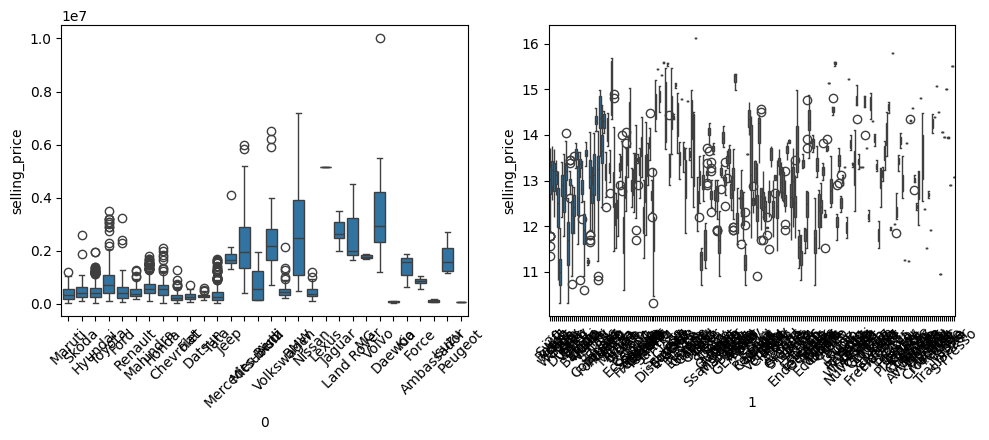

In [994]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

sns.boxplot(x=brand_train, y=y_train, ax=axes[0])
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(x=model_train, y=y_train_log, ax=axes[1])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

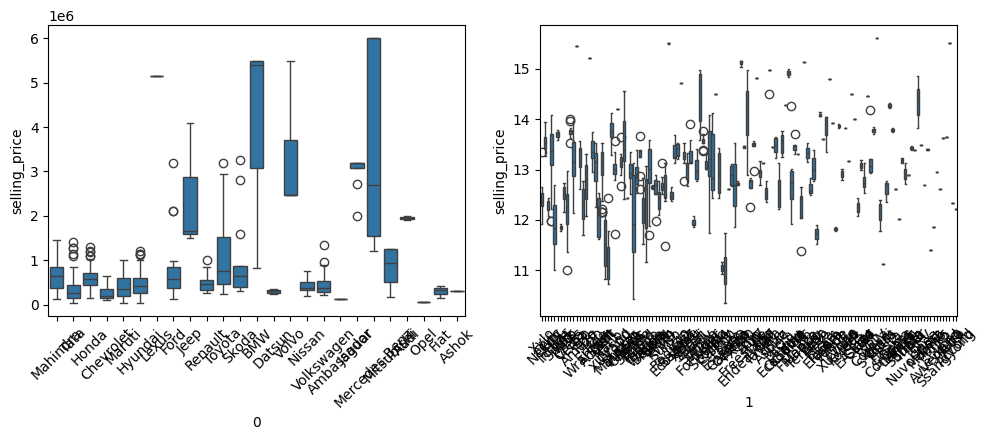

In [995]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

sns.boxplot(x=brand_test, y=y_test, ax=axes[0])
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(x=model_test, y=y_test_log, ax=axes[1])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### target переменная

In [996]:
y_train.shape, len(list(filter(lambda x: x > 0.3 * 10**7, y_train)))

((5840,), 45)

In [997]:
y_test.shape, len(list(filter(lambda x: x > 0.3 * 10**7, y_test)))

((1000,), 26)

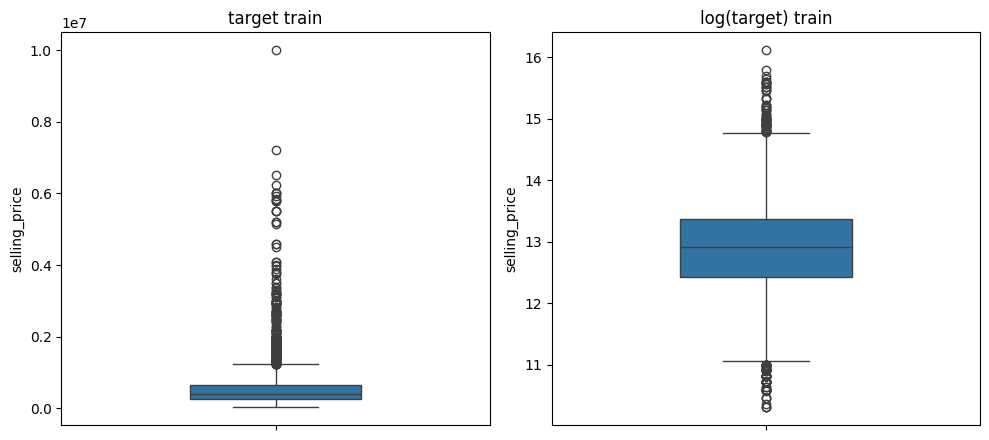

In [998]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

sns.boxplot(y=y_train, ax=axes[0], width=0.4)
axes[0].set_title('target train')

sns.boxplot(y=y_train_log, ax=axes[1], width=0.4)
axes[1].set_title('log(target) train')

plt.tight_layout()
plt.show()

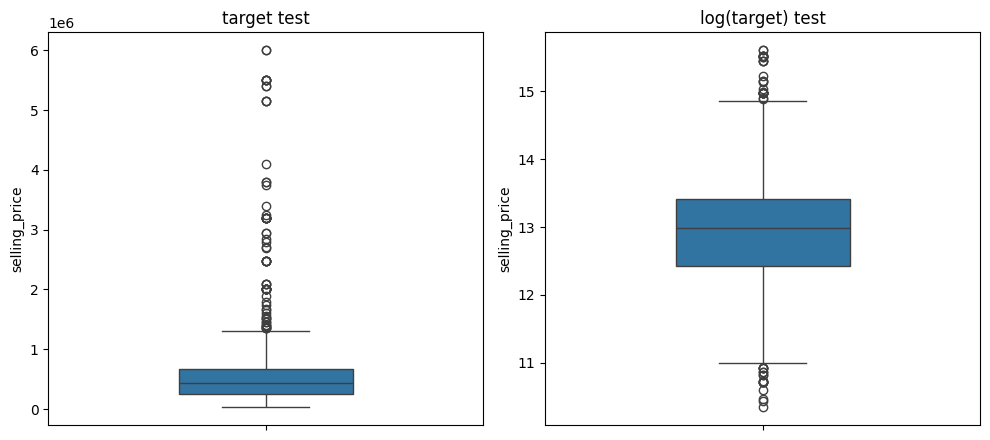

In [999]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

sns.boxplot(y=y_test, ax=axes[0], width=0.4)
axes[0].set_title('target test')

sns.boxplot(y=y_test_log, ax=axes[1], width=0.4)
axes[1].set_title('log(target) test')

plt.tight_layout()
plt.show()

#### категориальные признаки

In [1000]:
cat_cols = list(X_train_cat.select_dtypes(include=["object"]).columns)

In [1001]:
cat_cols

['fuel', 'seller_type', 'transmission', 'owner']

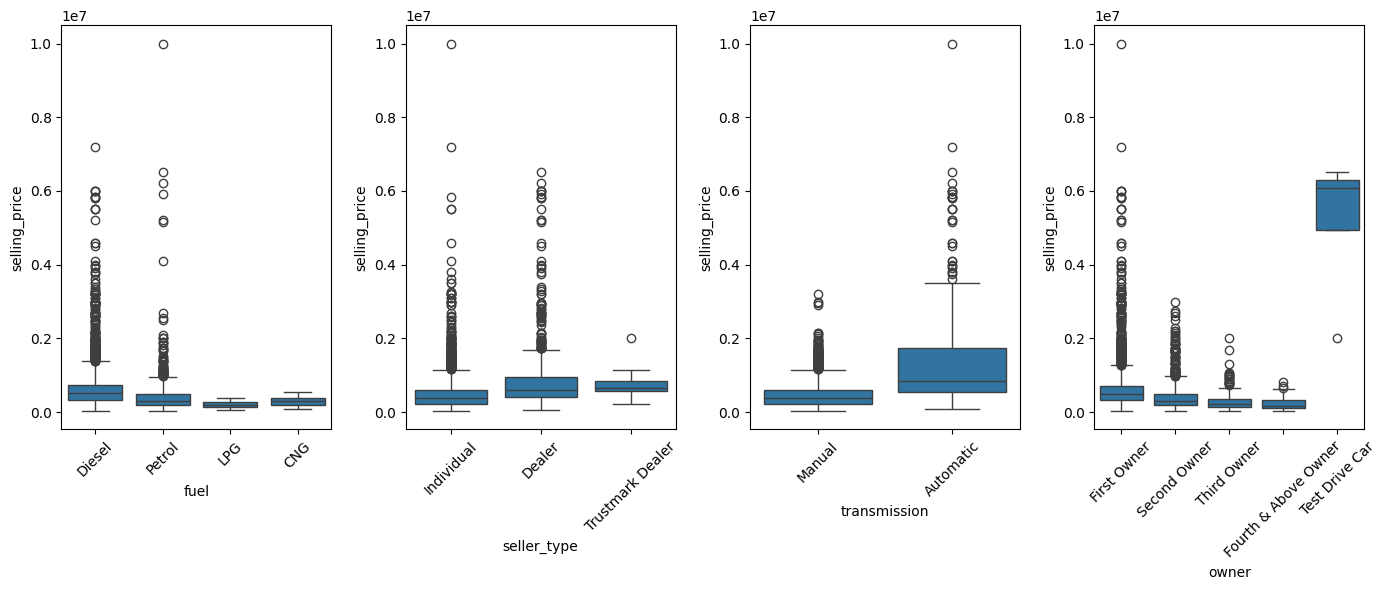

In [1002]:
fig, axes = plt.subplots(1, 4, figsize=(14, 6))

for i, cat in enumerate(cat_cols):
    sns.boxplot(data=X_train_cat, x=f'{cat}', y=y_train, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

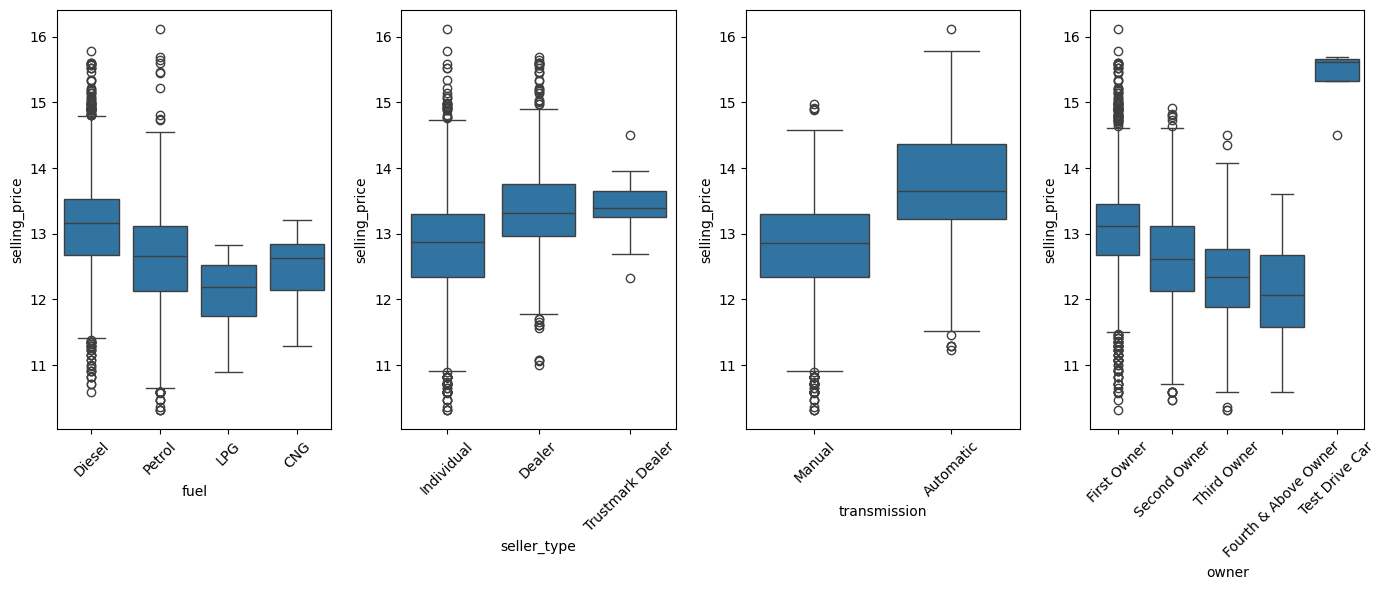

In [1003]:
fig, axes = plt.subplots(1, 4, figsize=(14, 6))

for i, cat in enumerate(cat_cols):
    sns.boxplot(data=X_train_cat, x=f'{cat}', y=y_train_log, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

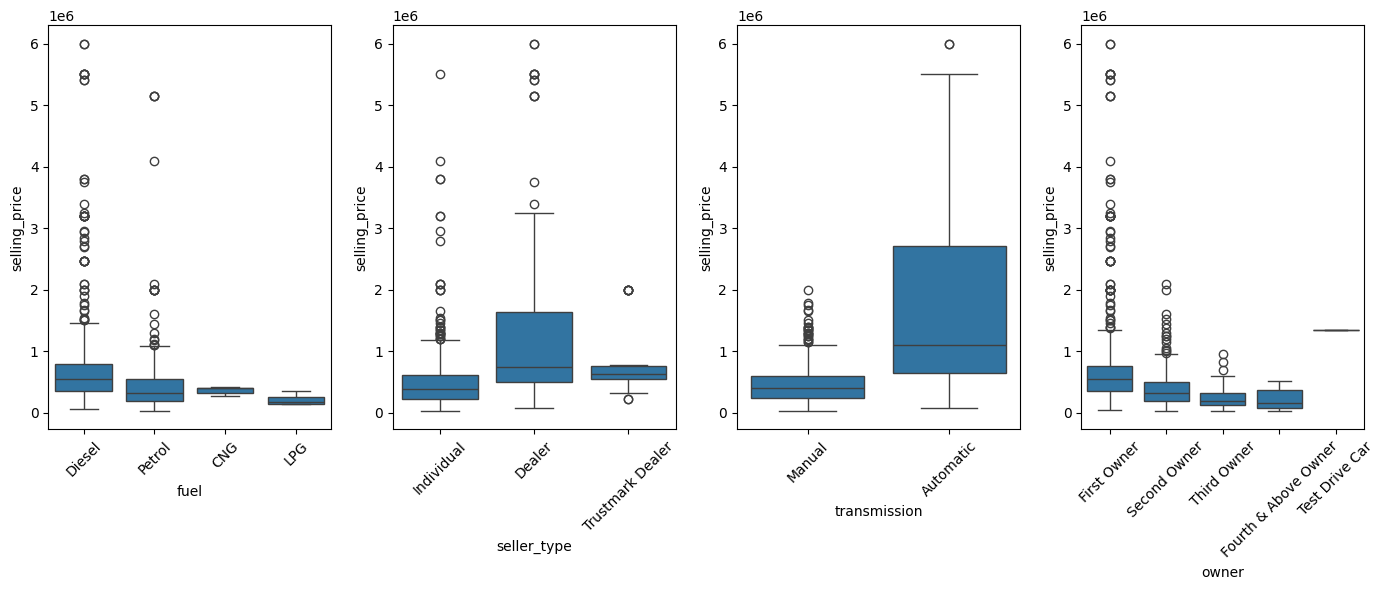

In [1004]:
fig, axes = plt.subplots(1, 4, figsize=(14, 6))

for i, cat in enumerate(cat_cols):
    sns.boxplot(data=X_test_cat, x=f'{cat}', y=y_test, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

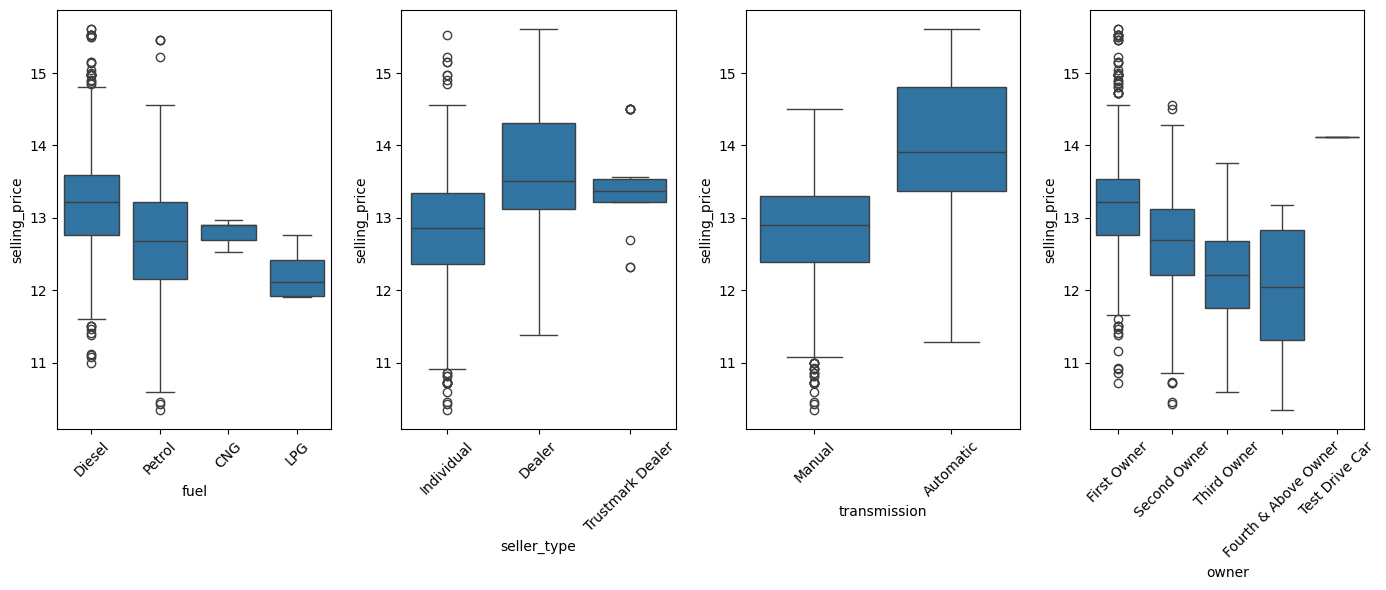

In [1005]:
fig, axes = plt.subplots(1, 4, figsize=(14, 6))

for i, cat in enumerate(cat_cols):
    sns.boxplot(data=X_test_cat, x=f'{cat}', y=y_test_log, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### зависимость цены x количества мест в машине

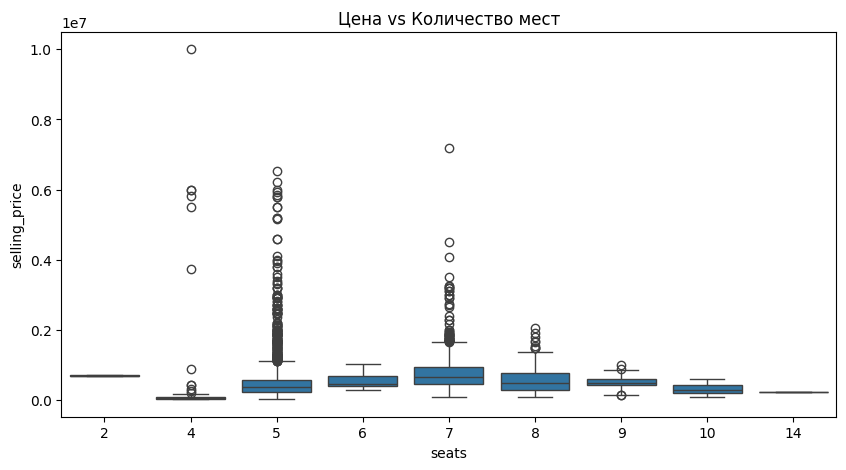

In [1006]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=X_train_cat, x='seats', y=y_train)
plt.title('Цена vs Количество мест')
plt.show()

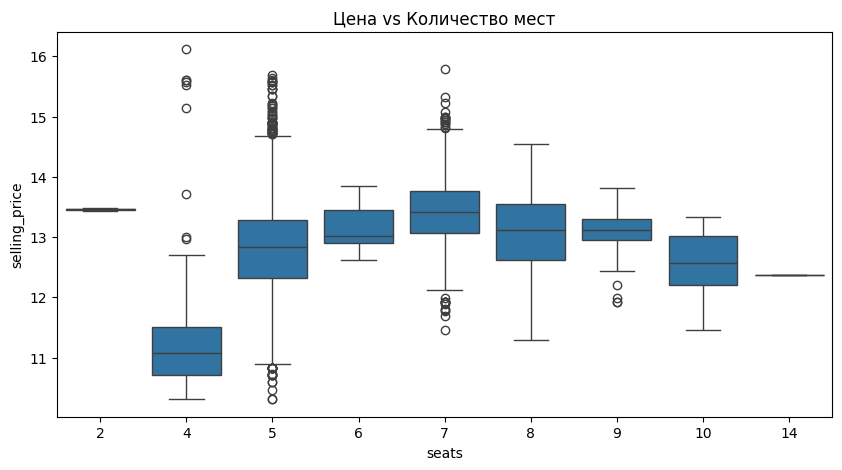

In [1007]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=X_train_cat, x='seats', y=y_train_log)
plt.title('Цена vs Количество мест')
plt.show()

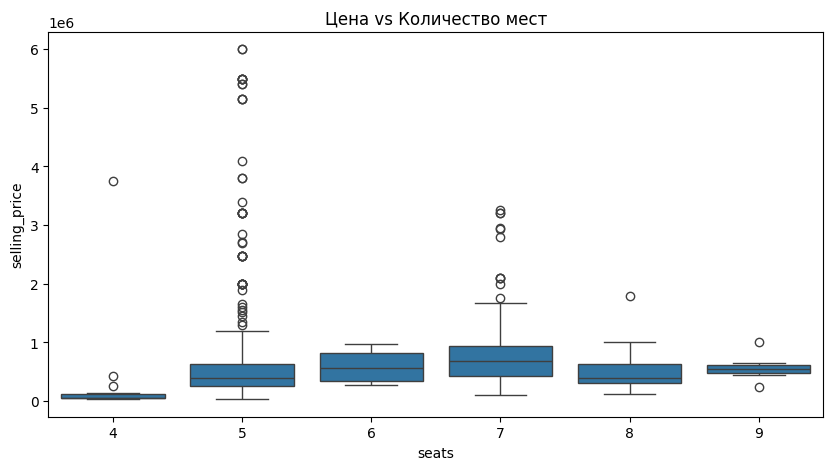

In [1008]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=X_test_cat, x='seats', y=y_test)
plt.title('Цена vs Количество мест')
plt.show()

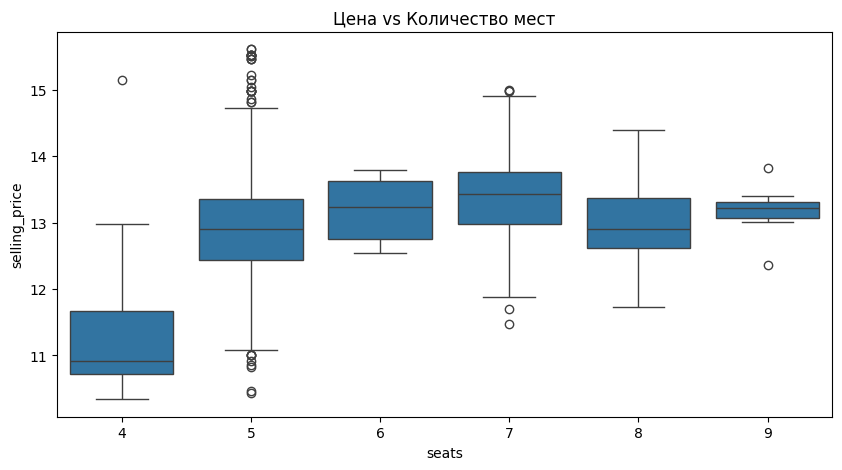

In [1009]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=X_test_cat, x='seats', y=y_test_log)
plt.title('Цена vs Количество мест')
plt.show()

#### предобработка и обработка данных

In [1010]:
# train выборка
for cat in cat_cols:
    print(Counter(X_train_cat[cat]))

Counter({'Diesel': 3177, 'Petrol': 2579, 'CNG': 50, 'LPG': 34})
Counter({'Individual': 5223, 'Dealer': 592, 'Trustmark Dealer': 25})
Counter({'Manual': 5336, 'Automatic': 504})
Counter({'First Owner': 3603, 'Second Owner': 1639, 'Third Owner': 454, 'Fourth & Above Owner': 140, 'Test Drive Car': 4})


In [1011]:
# test выборка
for cat in cat_cols:
    print(Counter(X_test_cat[cat]))

Counter({'Diesel': 534, 'Petrol': 457, 'CNG': 5, 'LPG': 4})
Counter({'Individual': 837, 'Dealer': 135, 'Trustmark Dealer': 28})
Counter({'Manual': 877, 'Automatic': 123})
Counter({'First Owner': 623, 'Second Owner': 278, 'Third Owner': 71, 'Fourth & Above Owner': 27, 'Test Drive Car': 1})


### **Задание 15 (0.4 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования. Обратите внимание, что во избежание мультиколлинеарности следует избавиться от одного из полученных столбцов при кодировании каждого признака методом OneHot.

In [1012]:
X_train_cat.seats = X_train_cat.seats.astype(str)
X_test_cat.seats = X_test_cat.seats.astype(str)

In [1043]:
def group_owner(owner):
    if owner in ['Third Owner', 'Fourth & Above Owner', 'Test Drive Car']:
        return 'Other Owner'
    else:
        return owner
    
X_train_cat['owner'] = X_train_cat['owner'].apply(group_owner)
X_test_cat['owner'] = X_test_cat['owner'].apply(group_owner)

In [1044]:
numeric_features = X_train_cat.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train_cat.select_dtypes(include=['object']).columns.tolist()

In [1045]:
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_cat[numeric_features])
X_test_num_scaled = scaler.transform(X_test_cat[numeric_features]) 

In [1046]:
ohe = OneHotEncoder(
    drop='first',
    sparse_output=False,
    handle_unknown='ignore',
    dtype=np.int64
)
X_train_cat_ohe = ohe.fit_transform(X_train_cat[categorical_features])
X_test_cat_ohe = ohe.transform(X_test_cat[categorical_features])

X_train_final = np.hstack([X_train_num_scaled, X_train_cat_ohe])
X_test_final = np.hstack([X_test_num_scaled, X_test_cat_ohe])

In [1047]:
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

In [1048]:
lr = LinearRegression()
lr.fit(X_train_final, y_train)

y_train_pred_encoded = lr.predict(X_train_final)
y_test_pred_encoded  = lr.predict(X_test_final)

r2_train_encoded = r2_score(y_train, y_train_pred_encoded)
r2_test_encoded  = r2_score(y_test, y_test_pred_encoded)

mse_train_encoded = MSE(y_train, y_train_pred_encoded)
mse_test_encoded  = MSE(y_test, y_test_pred_encoded)

rmse_train_encoded = mse_train_encoded ** 0.5
rmse_test_encoded = mse_test_encoded ** 0.5

mae_train = MAE(y_train, y_train_pred_encoded)
mae_test = MAE(y_test, y_test_pred_encoded)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_train = mape(y_train, y_train_pred_encoded)
mape_test = mape(y_test, y_test_pred_encoded)

In [1049]:
print(r2_train_encoded, mse_train_encoded, rmse_train_encoded, mae_train, mape_train)

0.6412694843513183 102825918923.80595 320664.807741364 177046.76002816047 55.333180949060946


In [1050]:
print(r2_test_encoded, mse_test_encoded, rmse_test_encoded, mae_test, mape_test)

0.6488464927910753 201853063356.28024 449280.6064769325 217086.21170228184 56.9363235068783


### **Задание 16 (0.25 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [1051]:
ridge = Ridge(random_state=42, max_iter=10000)

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
}

grid_ridge = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=10,
    scoring='r2',
    n_jobs=-1
)

grid_ridge.fit(X_train_final, y_train)

best_ridge = grid_ridge.best_estimator_

y_train_pred_ridge = best_ridge.predict(X_train_final)
y_test_pred_ridge  = best_ridge.predict(X_test_final)

r2_train_ridge = r2_score(y_train, y_train_pred_ridge)
r2_test_ridge  = r2_score(y_test, y_test_pred_ridge)

mse_train_ridge = MSE(y_train, y_train_pred_ridge)
mse_test_ridge = MSE(y_test, y_test_pred_ridge)

rmse_train_ridge = mse_train_ridge ** 0.5
rmse_test_ridge = mse_test_ridge ** 0.5

print("Лучшие параметры:", grid_ridge.best_params_)
print("Лучший скор (R²):", grid_ridge.best_score_)

Лучшие параметры: {'alpha': 10.0}
Лучший скор (R²): 0.619987454705308


In [1052]:
print(r2_train_ridge, mse_train_ridge, rmse_train_ridge)

0.6409698560714967 102911803876.05905 320798.69681165955


In [1053]:
print(r2_test_ridge, mse_test_ridge, rmse_test_ridge)

0.6480887503335483 202288635358.68643 449765.0890839422


In [1054]:
files_dir = os.path.join("../app", "files")
os.makedirs(files_dir, exist_ok=True)

model_path = os.path.join(files_dir, "linear_model_results.pkl")
pipeline_path = os.path.join(files_dir, "full_model_pipeline.pkl")

In [1055]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

In [1056]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [1057]:
pipeline.fit(X_train_cat, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [1058]:
with open(pipeline_path, "wb") as f:
    pickle.dump(pipeline, f)

In [1059]:
user_input = pd.DataFrame([{
    'name': 'Maruti Swift',
    'year': 2018,
    'km_driven': 35000,
    'fuel': 'Petrol',
    'seller_type': 'Individual',
    'transmission': 'Manual',
    'owner': 'First Owner',
    'engine': 1197,
    'max_power': 82,
    'seats': '5',
    'mileage': 22.0
}])

predicted = pipeline.predict(user_input)

In [1060]:
predicted[0]

np.float64(597348.7332868098)

In [1061]:
lr_results = {
    'model': lr,
    
    'metrics': {
        'r2_train': r2_train_encoded,
        'r2_test': r2_test_encoded,
        'mse_train': mse_train_encoded,
        'mse_test': mse_test_encoded,
        'rmse_train': rmse_train_encoded,
        'rmse_test': rmse_test_encoded,
    },
    
    'coefficients': lr.coef_.tolist(),
    'intercept': lr.intercept_,
    
    'orig_feature_names': numeric_features + categorical_features,
    'feature_names': numeric_features + list(ohe_feature_names),
    
    'model_type': 'LinearRegression',
    'note': 'No hyperparameter tuning or cross-validation used'
}

with open(model_path, 'wb') as f:
    pickle.dump(lr_results, f)

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 17 (0.5 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какая лучше всего решает задачу бизнеса

In [1062]:
def business_metric(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if np.any(y_true == 0):
        raise ValueError("y_true содержит нулевые значения, что делает невозможным вычисление относительной ошибки.")
    
    relative_error = np.abs(y_pred - y_true) / np.abs(y_true)
    
    accuracy_within_10pct = np.mean(relative_error <= 0.1)
    
    return accuracy_within_10pct

In [1063]:
business_metric(y_test, y_test_pred) # lr модель (вещ)

np.float64(0.227)

In [1064]:
business_metric(y_test, y_test_pred_scaled) # scaled модель

np.float64(0.227)

In [1065]:
business_metric(y_test, y_test_pred_lasso) # lasso модель

np.float64(0.227)

In [1066]:
business_metric(y_test, y_test_pred_lasso_grid) # lasso grid модель

np.float64(0.235)

In [1067]:
business_metric(y_test, y_test_pred_elastic) # elastic grid модель

np.float64(0.241)

In [1068]:
business_metric(y_test, y_test_pred_encoded) # lr модель (вещ + кат)

np.float64(0.24)

In [1069]:
business_metric(y_test, y_test_pred_ridge) # ridge grid модель

np.float64(0.24)

`Your answer here`

# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 18 (1 балл)**


**Результаты вашей работы** необходимо разместить в своем Гитхабе. Далее в этот же репозиторий вы прикрепите вторую часть. Под результатами первой части понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)
